# Exercise 1

For this assignment, I cannot use my UNFCCC decisions data becuase there is no categorization for us to assess our models. Instead, I sliced up UNFCCC handbook pages as texts and categorized them according to which chapter they are in. Although this is highly artificial, it will allow me to explore if climate change regulatory wording for different topics are vastly different.

In [9]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [21]:
print(sklearn.__version__)

0.22.1


# vectorize doc (bow)

In [3]:
indus = pd.read_csv('master_industry.csv')

In [5]:
indus['gind'] = indus['gind'].astype(str)

In [7]:
indus['wanted1'] = indus['gind'].str.startswith('10', na=False)

In [8]:
indus['wanted2'] = indus['gind'].str.startswith('15', na=False)
indus['wanted3'] = indus['gind'].str.startswith('45', na=False)
indus['wanted4'] = indus['gind'].str.startswith('40', na=False)

In [9]:
indus_wanted = indus[(indus['wanted1']== True)|(indus['wanted2'] ==True) \
                        |(indus['wanted3'] ==True )|(indus['wanted4'] ==True )]

In [10]:
indus.head(10)

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4
0,12994,20100331,10001,0.006574,0.004792,-0.0036,0000950123-10-030755.txt,551020.0,False,False,False,False
1,12994,20110404,10001,-0.010405,0.002545,0.0009,0000950123-11-032614.txt,551020.0,False,False,False,False
2,12994,20120410,10001,-0.004503,-0.012281,-0.0185,0001193125-12-157390.txt,551020.0,False,False,False,False
3,12994,20130401,10001,0.034031,0.013726,-0.0057,0001193125-13-136685.txt,551020.0,False,False,False,False
4,12994,20140331,10001,-0.021659,0.007007,0.0097,0001193125-14-123966.txt,551020.0,False,False,False,False
5,12994,20150312,10001,-0.006624,0.000000,0.0128,0001144204-15-015657.txt,551020.0,False,False,False,False
6,12994,20160315,10001,0.007276,-0.010025,-0.0036,0001144204-16-088193.txt,551020.0,False,False,False,False
7,11903,20100114,10025,-0.030430,0.023926,0.0024,0001193125-10-006494.txt,151030.0,False,True,False,False
8,11903,20110114,10025,0.066290,0.066775,0.0069,0001193125-11-008295.txt,151030.0,False,True,False,False
9,11903,20120117,10025,0.034458,0.029080,0.0036,0001193125-12-013914.txt,151030.0,False,True,False,False


In [24]:
def categorize(x):
    
    if x.startswith('10'):
        cat = 'energy'
    elif x.startswith('15'):
        cat = 'material'
    elif x.startswith('45'):
        cat = 'IT'
    else:
        cat = 'finance'
        
    return cat

In [26]:
indus_wanted['category'] = indus_wanted['gind'].apply(lambda x: categorize(x))

/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
indus_wanted[indus_wanted['category'] == 'finance']

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4,category
80,12138,20100205,10138,-0.014425,0.012430,0.0029,0000950123-10-009025.txt,402030.0,False,False,False,True,finance
81,12138,20110208,10138,0.007117,0.003582,0.0048,0000950123-11-010348.txt,402030.0,False,False,False,True,finance
82,12138,20120203,10138,-0.014630,0.025065,0.0158,0001193125-12-038736.txt,402030.0,False,False,False,True,finance
83,12138,20130205,10138,-0.001402,0.009505,0.0107,0001113169-13-000010.txt,402030.0,False,False,False,True,finance
84,12138,20140204,10138,-0.001256,0.026563,0.0077,0001113169-14-000007.txt,402030.0,False,False,False,True,finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,64193,20160324,93131,0.015359,0.030924,0.0000,0001144204-16-089928.txt,401010.0,False,False,False,True,finance
37691,64193,20170324,93131,0.067777,0.066079,-0.0005,0001628280-17-002874.txt,401010.0,False,False,False,True,finance
37692,64193,20180321,93131,-0.007440,0.030928,-0.0006,0001628280-18-003446.txt,401010.0,False,False,False,True,finance
37693,64193,20190322,93131,0.031004,0.006410,-0.0217,0001437749-19-005481.txt,401010.0,False,False,False,True,finance


In [31]:
with open('indus_wanted.pkl', 'wb') as handle:
    pickle.dump(indus_wanted, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Starting here

In [10]:
import pickle 

with open('indus_wanted.pkl', 'rb') as handle:
    indus_wanted = pickle.load(handle)

indus_wanted

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4,category
7,11903,20100114,10025,-0.030430,0.023926,0.0024,0001193125-10-006494.txt,151030.0,False,True,False,False,material
8,11903,20110114,10025,0.066290,0.066775,0.0069,0001193125-11-008295.txt,151030.0,False,True,False,False,material
9,11903,20120117,10025,0.034458,0.029080,0.0036,0001193125-12-013914.txt,151030.0,False,True,False,False,material
10,11903,20130122,10025,-0.004012,0.000162,0.0048,0001193125-13-019043.txt,151030.0,False,True,False,False,material
11,11903,20140114,10025,0.012214,0.035475,0.0115,0001193125-14-010742.txt,151030.0,False,True,False,False,material
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37715,66228,20100728,93398,-0.110737,0.001770,-0.0082,0000943440-10-000447.txt,101020.0,True,False,False,False,energy
37716,66228,20110729,93398,-0.426273,-0.183333,-0.0056,0000943440-11-000404.txt,101020.0,True,False,False,False,energy
37717,66228,20120716,93398,-0.122059,-0.054348,-0.0031,0000785968-12-000030.txt,101020.0,True,False,False,False,energy
37718,66228,20130715,93398,-0.003624,-0.007389,0.0020,0000785968-13-000065.txt,101020.0,True,False,False,False,energy


In [11]:
#import pickle
with open('TFVects.pkl', 'rb') as handle:
    TFVects = pickle.load(handle)

In [12]:
type(TFVects)

scipy.sparse.csr.csr_matrix

In [13]:
TFVects.shape

(37720, 43150)

In [14]:
tf_arr = TFVects.toarray()

In [15]:
type(tf_arr)

numpy.ndarray

In [10]:
indus_wanted.index
tf_arr[list(indus_wanted.index)].shape

Int64Index([    7,     8,     9,    10,    11,    12,    33,    34,    35,
               36,
            ...
            37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718,
            37719],
           dtype='int64', length=16411)

In [16]:
TFVects = tf_arr[list(indus_wanted.index)]

In [18]:
with open('TFVects_wanted.pkl', 'wb') as handle:
    pickle.dump(TFVects, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('TFVectorizer.pkl', 'rb') as handle:
    TFVectorizer = pickle.load(handle)


/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### 6 topics 

In [32]:
import time

start = time.time()
km = sklearn.cluster.KMeans(n_clusters=6, init='k-means++')
km.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 3975.1330358982086


In [33]:
#And we look at the scores of this clustering
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

In [42]:
with open('km6.pkl', 'wb') as handle:
    pickle.dump(km, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open('km6.pkl', 'rb') as handle:
    km = pickle.load(handle)

The categories' colors are:
dict_items([('energy', 'blue'), ('material', 'red'), ('IT', 'orange'), ('finance', 'green')])


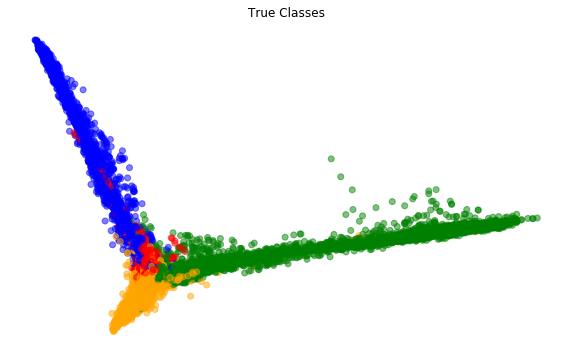

In [35]:
# plotting

PCA = sklearn.decomposition.PCA
#pca = PCA(n_components = 2).fit(TFVects.toarray())
pca = PCA(n_components = 2).fit(TFVects)
#reduced_data = pca.transform(TFVects.toarray())
reduced_data = pca.transform(TFVects)

colordict = {
 'energy':'blue',
'material':'red',
    'IT':'orange',
    'finance':'green'}
    

colors = [colordict[c] for c in indus_wanted['category']]
print("The categories' colors are:\n{}".format(colordict.items()))


fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [28]:
with open('pca.pkl', 'wb') as handle:
    pickle.dump(pca, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('reduced_data.pkl', 'wb') as handle:
    pickle.dump(reduced_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

The categories' colors are:
dict_items([('energy', 'blue'), ('material', 'red'), ('IT', 'orange'), ('finance', 'green')])


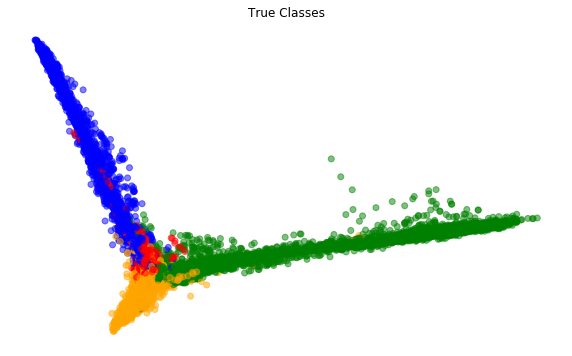

In [27]:
# plotting

PCA = sklearn.decomposition.PCA
#pca = PCA(n_components = 2).fit(TFVects.toarray())
pca = PCA(n_components = 2).fit(TFVects)
#reduced_data = pca.transform(TFVects.toarray())
reduced_data = pca.transform(TFVects)

colordict = {
 'energy':'blue',
'material':'red',
    'IT':'orange',
    'finance':'green'}
    

colors = [colordict[c] for c in indus_wanted['category']]
print("The categories' colors are:\n{}".format(colordict.items()))


fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [24]:
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(6):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 reinsurance
 premiums
 catastrophe
 lae
 accident
 underwriting
 written
 premium
 casualty
 ceded


Cluster 1:
 gas
 oil
 natural
 drilling
 proved
 properties
 wells
 crude
 exploration
 boe


Cluster 2:
 software
 subscription
 license
 cloud
 research
 solutions
 hardware
 vsoe
 licenses
 headcount


Cluster 3:
 research
 restructuring
 currency
 manufacturing
 solutions
 semiconductor
 software
 warranty
 pension
 percent


Cluster 4:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb


Cluster 5:
 mortgage
 oil
 gas
 unrealized
 ebitda
 crude
 coal
 aum
 distributions
 drilling




In [29]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

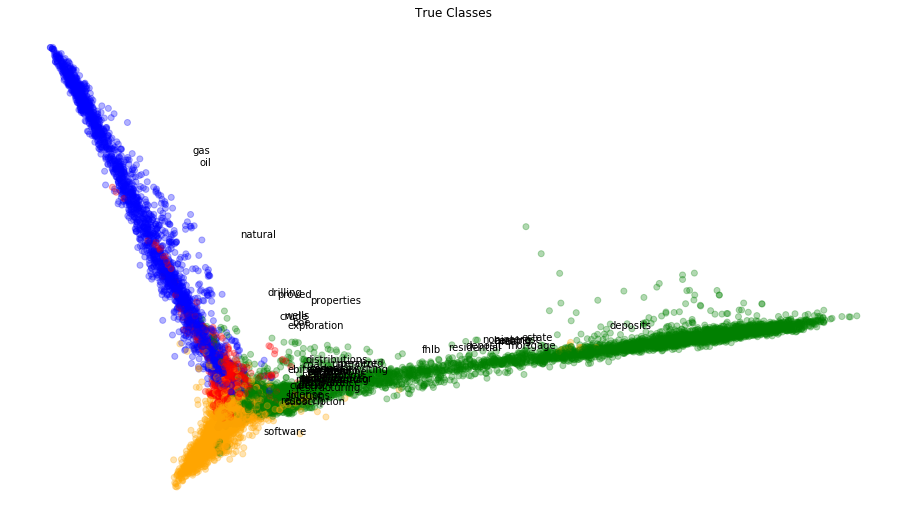

In [30]:

fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

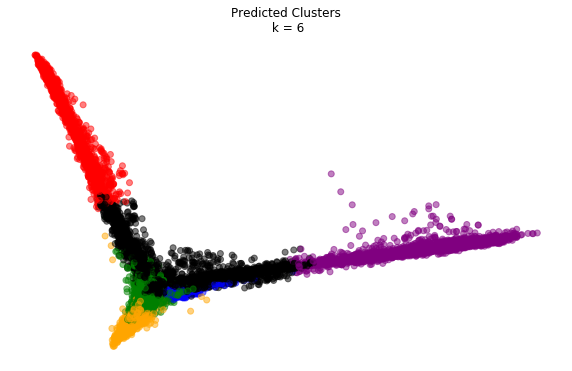

In [45]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green',4:'purple', 5:'black'}
colors_p = [Cat_col[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 6')
plt.show()

### 4 Topics

In [31]:
with open('km4.pkl', 'rb') as handle:
    km4 = pickle.load(handle)


In [32]:
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km4.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 gas
 oil
 natural
 drilling
 proved
 properties
 crude
 wells
 exploration
 boe


Cluster 1:
 reinsurance
 premiums
 catastrophe
 lae
 accident
 underwriting
 written
 premium
 casualty
 ceded


Cluster 2:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb


Cluster 3:
 software
 research
 solutions
 restructuring
 currency
 subscription
 license
 ebitda
 manufacturing
 percent




In [39]:
start = time.time()
km4 = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')
km4.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 6242.4488260746


In [41]:
with open('km4.pkl', 'wb') as handle:
    pickle.dump(km4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
#And we look at the scores of this clustering
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km4.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km4.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km4.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km4.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

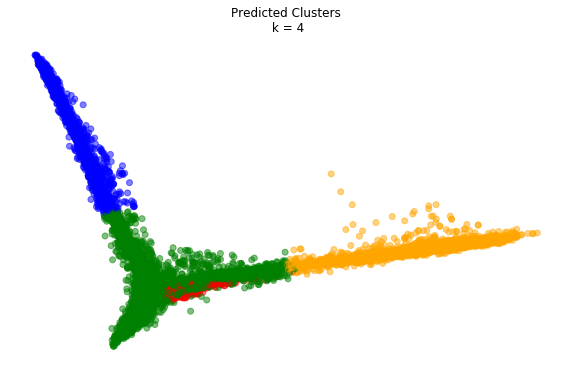

In [47]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green'}
colors_p = [Cat_col[l] for l in km4.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

### 3 Topics

In [33]:
with open('km3.pkl', 'rb') as handle:
    km3 = pickle.load(handle)
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km3.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 software
 research
 solutions
 restructuring
 currency
 subscription
 reinsurance
 license
 ebitda
 premiums


Cluster 1:
 gas
 oil
 natural
 drilling
 proved
 properties
 crude
 wells
 exploration
 boe


Cluster 2:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb




In [48]:
start = time.time()
km3 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')
km3.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 4863.359057188034


In [49]:
with open('km3.pkl', 'wb') as handle:
    pickle.dump(km3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km3.labels_)))

For our clusters:
Homogeneity: 0.298
Completeness: 0.484
V-measure: 0.369
Adjusted Rand Score: 0.163


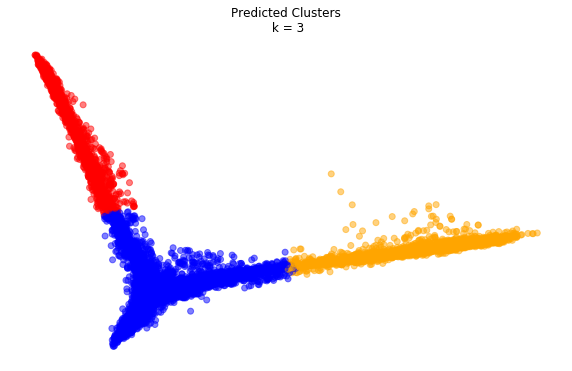

In [51]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange'}
colors_p = [Cat_col[l] for l in km3.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

### topics = 2

In [34]:
with open('km2.pkl', 'rb') as handle:
    km2 = pickle.load(handle)
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km2.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 gas
 oil
 software
 natural
 research
 solutions
 restructuring
 currency
 subscription
 drilling


Cluster 1:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb




In [53]:
start = time.time()
km2 = sklearn.cluster.KMeans(n_clusters=2, init='k-means++')
km2.fit(TFVects)
print('time elapsed:', time.time()-start)
with open('km2.pkl', 'wb') as handle:
    pickle.dump(km2, handle, protocol=pickle.HIGHEST_PROTOCOL)

time elapsed: 5289.469854831696


In [54]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km2.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km2.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km2.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km2.labels_)))

For our clusters:
Homogeneity: 0.164
Completeness: 0.425
V-measure: 0.237
Adjusted Rand Score: 0.054


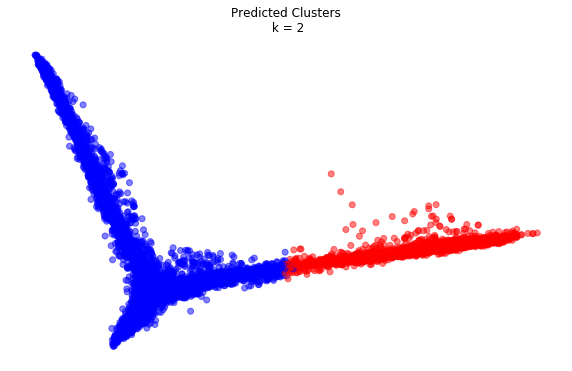

In [55]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange'}
colors_p = [Cat_col[l] for l in km2.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

### topics = 5

In [ ]:
import time
start = time.time()
km5 = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')
km5.fit(TFVects)

print('time elapsed:', time.time()-start)
with open('km5.pkl', 'wb') as handle:
    pickle.dump(km5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km5.labels_)))

In [ ]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green',4:'purple'}
colors_p = [Cat_col[l] for l in km5.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

 ### needs feature names

In [28]:
#Now look at the distinguishing features in each cluster
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(6):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 clinical
 research
 trial
 trials
 drug
 candidates
 milestone
 license
 patients
 fda


Cluster 1:
 2017
 2018
 2019
 2020
 segment
 asu
 inventory
 currency
 endeddecember
 ebitda


Cluster 2:
 segment
 inventory
 software
 currency
 research
 asu
 convertible
 senior
 endeddecember
 ebitda


Cluster 3:
 gas
 oil
 natural
 drilling
 energy
 wells
 properties
 exploration
 crude
 electric


Cluster 4:
 2008
 2007
 asc
 fasb
 segment
 thecompany
 inventory
 software
 research
 restructuring


Cluster 5:
 deposits
 estate
 real
 portfolio
 earning
 mortgage
 bearing
 deposit
 noninterest
 residential




In [46]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

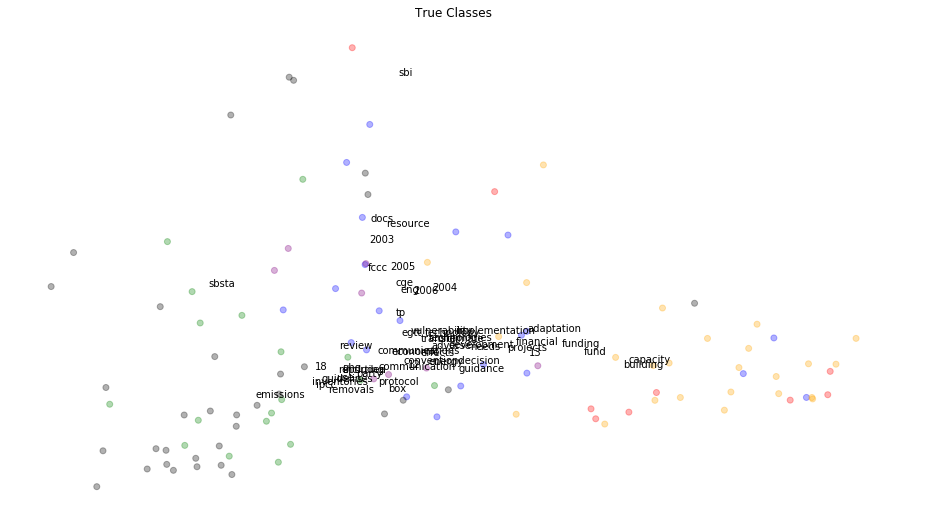

In [47]:

fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [49]:
#Now let us look at predicted clusters
Categories= ['adaptation','capacity_build','finance','mitigation','transfer','transparency']
colors_p = [colordict[Categories[l]] for l in km.labels_]

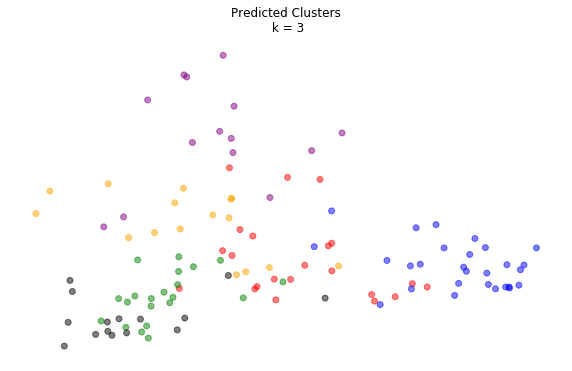

In [50]:

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

### Note:
We don't see clear seperation in the topics. I suspect is becuase UNFCCC documents have a relatively small vocavulary size and the use of vocabularies are overlapped in many different topics. The regulatory regime is interrelated between topics. Topic modeling may not be a useful tool if no further refined preprocessing is in place.

In [51]:
#Now let us test what is the best number of clusters
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
        
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


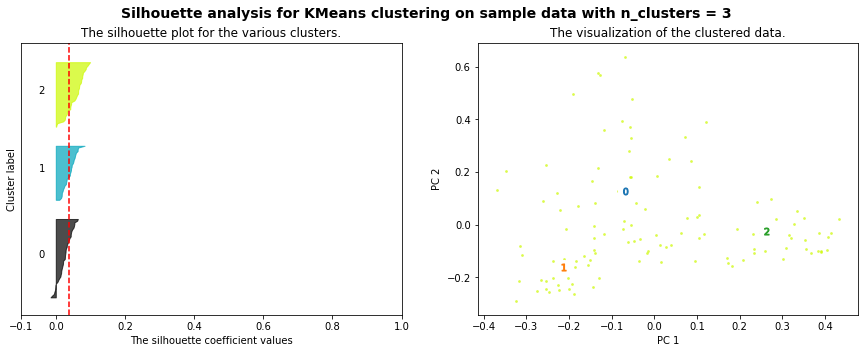

For n_clusters = 3, The average silhouette_score is : 0.039


In [53]:
#The original categories
X = TFVects.toarray()
plotSilhouette(3, X)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


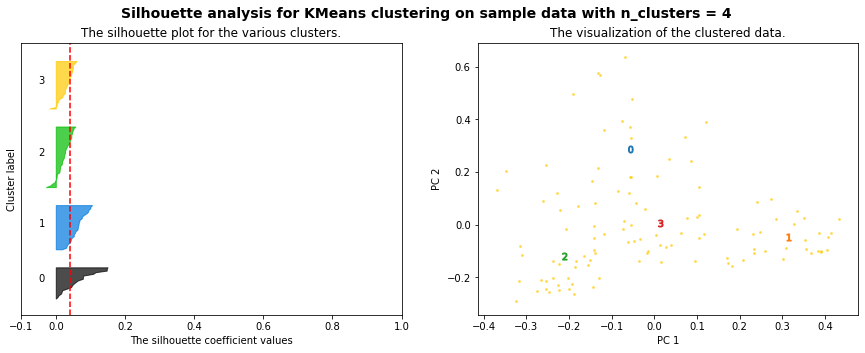

For n_clusters = 4, The average silhouette_score is : 0.041


In [55]:

#If the number of clusters = 4
X = TFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


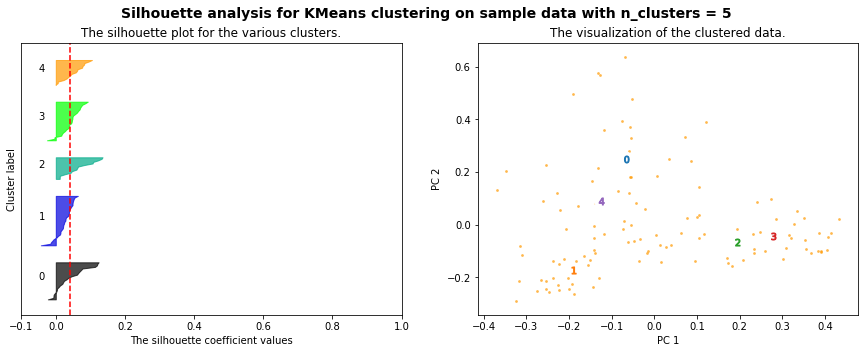

For n_clusters = 5, The average silhouette_score is : 0.042


In [56]:

#If the number of clusters = 5
X = TFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


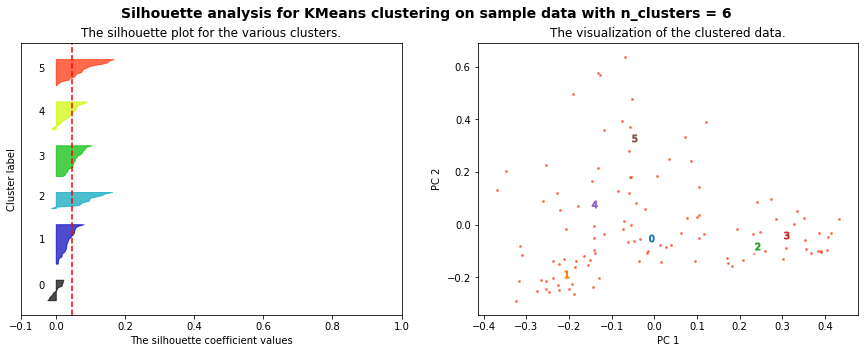

For n_clusters = 6, The average silhouette_score is : 0.046


In [61]:
#If the number of clusters = 6
X = TFVects.toarray()
plotSilhouette(6, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


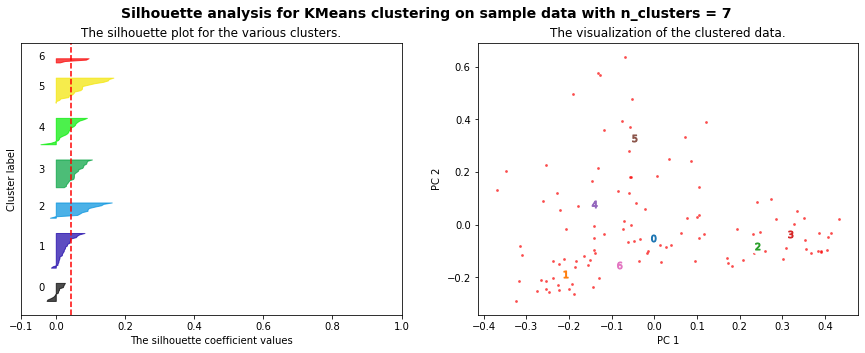

For n_clusters = 7, The average silhouette_score is : 0.045


In [68]:
#If the number of clusters = 7
X = TFVects.toarray()
plotSilhouette(7, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


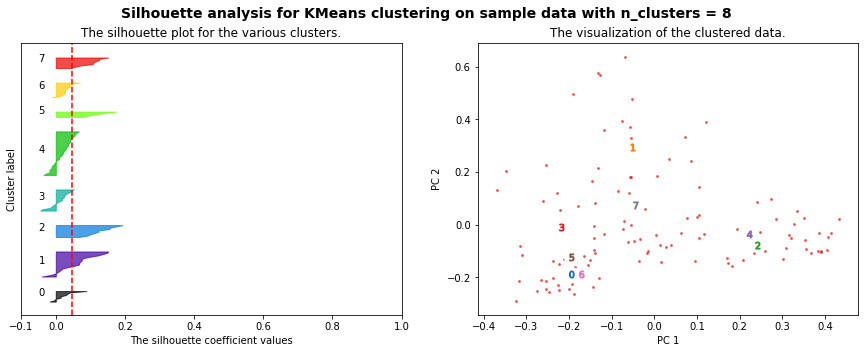

For n_clusters = 8, The average silhouette_score is : 0.046


In [70]:
#If the number of clusters = 8
X = TFVects.toarray()
plotSilhouette(8, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


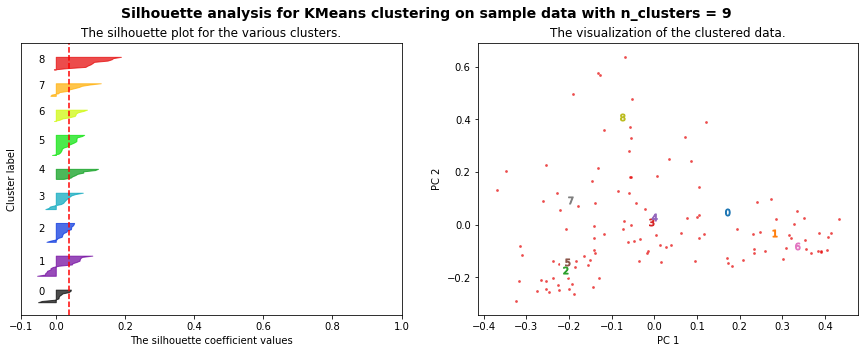

For n_clusters = 9, The average silhouette_score is : 0.039


In [71]:
#If the number of clusters = 9
X = TFVects.toarray()
plotSilhouette(9, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


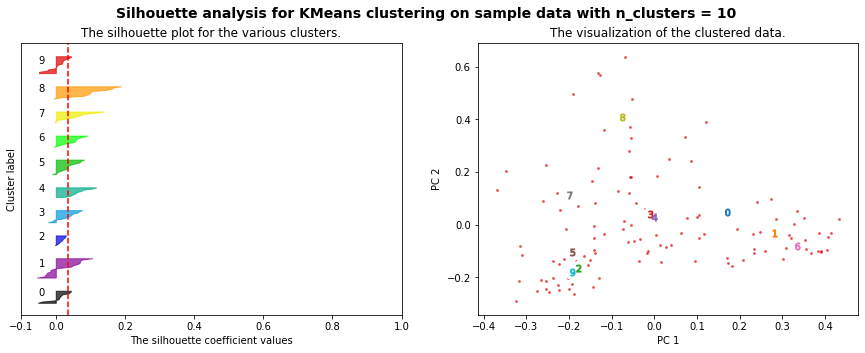

For n_clusters = 10, The average silhouette_score is : 0.036


In [69]:
#If the number of clusters = 10
X = TFVects.toarray()
plotSilhouette(10, X)

### Note:
From the score rendered by the silhouette, we see that 8 topics gives the best score.


# Exercise 2

In [73]:
TFVects.shape

(116, 1000)

In [74]:
set(df['category'])

{'adaptation',
 'capacity_build',
 'finance',
 'mitigation',
 'transfer',
 'transparency'}

In [59]:

CoocMat = TFVects * TFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
CoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accura

selectIndices = []
indexToCat = []
for c in set(df['category']):
    selectIndices += list(df[df['category'] == c].index)[:50]
    indexToCat += [c] * 50

subCoocMat = CoocMat[selectIndices,:][:,selectIndices]

linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[  3.        ,  29.        ,   0.56637116,   2.        ],
       [ 67.        ,  84.        ,   0.57025111,   2.        ],
       [ 92.        ,  94.        ,   0.5792153 ,   2.        ],
       [109.        , 110.        ,   0.58144586,   2.        ],
       [ 88.        ,  97.        ,   0.5870083 ,   2.        ],
       [  0.        ,  11.        ,   0.59922034,   2.        ],
       [ 32.        , 116.        ,   0.61476392,   3.        ],
       [ 42.        ,  44.        ,   0.64283196,   2.        ],
       [ 69.        , 103.        ,   0.65200389,   2.        ],
       [ 63.        ,  75.        ,   0.65658274,   2.        ]])

In [82]:
linkage_matrix

array([[  3.        ,  29.        ,   0.56637116,   2.        ],
       [ 67.        ,  84.        ,   0.57025111,   2.        ],
       [ 92.        ,  94.        ,   0.5792153 ,   2.        ],
       [109.        , 110.        ,   0.58144586,   2.        ],
       [ 88.        ,  97.        ,   0.5870083 ,   2.        ],
       [  0.        ,  11.        ,   0.59922034,   2.        ],
       [ 32.        , 116.        ,   0.61476392,   3.        ],
       [ 42.        ,  44.        ,   0.64283196,   2.        ],
       [ 69.        , 103.        ,   0.65200389,   2.        ],
       [ 63.        ,  75.        ,   0.65658274,   2.        ],
       [ 35.        ,  47.        ,   0.6592538 ,   2.        ],
       [  8.        ,  14.        ,   0.65926402,   2.        ],
       [  5.        ,  10.        ,   0.66917397,   2.        ],
       [ 71.        ,  80.        ,   0.67385291,   2.        ],
       [ 40.        ,  41.        ,   0.67861197,   2.        ],
       [ 33.        ,  53

In [72]:
linkage_matrix.shape

(115, 4)

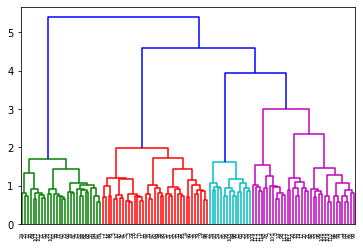

In [60]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

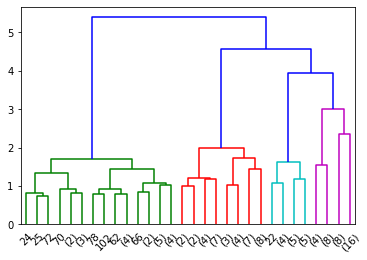

In [62]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [75]:
#If I cluster the corpora using original categories:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 6, 'maxclust')
hierarchicalClusters

array([2, 6, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 3, 2, 5, 5, 5, 5, 5,
       3, 3, 1, 1, 5, 2, 2, 2, 2, 2, 2, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 4, 2, 2, 2, 2, 2, 2, 2, 6, 3, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 6,
       6, 3, 3, 6, 6, 3, 6, 3, 6, 6, 4, 6, 4, 1, 1, 1, 4, 3, 6, 5, 6, 6,
       6, 5, 4, 4, 4, 4], dtype=int32)

In [80]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 6, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.427
Completeness: 0.431
V-measure: 0.429
Adjusted Rand Score: 0.378


/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [78]:
#If I cluster the corpora using optimal categories suggested by Silhouette score:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 8, 'maxclust')
hierarchicalClusters

array([2, 8, 6, 2, 4, 2, 2, 2, 6, 4, 2, 2, 2, 2, 6, 5, 2, 7, 7, 7, 7, 7,
       5, 5, 1, 1, 7, 4, 4, 2, 4, 4, 2, 8, 5, 3, 3, 4, 4, 4, 2, 2, 4, 6,
       4, 6, 4, 3, 3, 3, 4, 4, 4, 8, 5, 1, 5, 5, 5, 3, 3, 1, 1, 1, 1, 5,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 8,
       8, 5, 5, 8, 8, 5, 8, 5, 8, 8, 6, 8, 6, 1, 1, 1, 6, 5, 8, 7, 8, 8,
       8, 7, 6, 6, 6, 6], dtype=int32)

In [81]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 8, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.477
Completeness: 0.400
V-measure: 0.435
Adjusted Rand Score: 0.318


/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


### Note:
From the binary tree above we see early seperation between unbalanced text. This shows that some topics are more closely related than others.

# Exercise 3

In [193]:
with open('handbook_cat.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [194]:
#Normalize the data
df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))



In [195]:
Training, Testing = sklearn.model_selection.train_test_split(df, test_size=0.5, 
                                         train_size=0.5,  shuffle=True, )


TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(df['text'])

#Drop Missing ones
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
Training['reduced_tokens'] = Training['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

dictionary = gensim.corpora.Dictionary(Training['reduced_tokens'])

corpus = [dictionary.doc2bow(text) for text in Training['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('df.mm', corpus)
dfmm = gensim.corpora.MmCorpus('df.mm')

/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [189]:
Training.columns

Index(['text_id', 'category', 'text', 'tokenized_text', 'normalized_tokens',
       'reduced_tokens'],
      dtype='object')

In [196]:
Training

,text_id,category,text,tokenized_text,normalized_tokens,reduced_tokens
41,finance-11,finance,124UNFCCC Handbook13Fund) and the newly establ...,"[124UNFCCC, Handbook13Fund, and, the, newly, e...","[124unfccc, handbook13fund, newly, establish, ...","[newly, establish, sccf, decision, direct, sup..."
46,finance-16,finance,basic and essential level ofinformation to ena...,"[basic, and, essential, level, ofinformation, ...","[basic, essential, level, ofinformation, enabl...","[basic, essential, level, ofinformation, enabl..."
33,finance-3,finance,116UNFCCC Handbook1313.A.1. Institutional arra...,"[116UNFCCC, Handbook1313.A.1, Institutional, a...","[116unfccc, handbook1313.a.1, institutional, a...","[institutional, convention, mechanism, provisi..."
26,capacity_build-5,capacity_build,17.B.2. Review of implementationDecisions 2/CP...,"[17.B.2, Review, of, implementationDecisions, ...","[17.b.2, review, implementationdecisions, cp.7...","[review, mandate, cop, conduct, implementation..."
100,transparency-19,transparency,Communicating information on implementation189...,"[Communicating, information, on, implementatio...","[communicate, information, implementation18918...","[communicate, information, provide, publish, i..."
7,adaptation-8,adaptation,Adapting to climate change9912Decision 28/CP.7...,"[Adapting, to, climate, change9912Decision, 28...","[adapt, climate, change9912decision, cp.7, inc...","[adapt, climate, include, preparation, ofnapas..."
47,finance-17,finance,130UNFCCC Handbook13introduction ofstrategic p...,"[130UNFCCC, Handbook13introduction, ofstrategi...","[130unfccc, handbook13introduction, ofstrategi...","[ofstrategic, priority, new, strategic, approa..."
102,transparency-21,transparency,Communicating information on implementation191...,"[Communicating, information, on, implementatio...","[communicate, information, implementation19118...","[communicate, information, initial, inventory,..."
29,capacity_build-8,capacity_build,The aim ofNCSAs is to identify national priori...,"[The, aim, ofNCSAs, is, to, identify, national...","[aim, ofncsas, identify, national, priority, n...","[aim, identify, national, priority, need, capa..."
52,finance-22,finance,Funding for NAPAs is provided on the basis off...,"[Funding, for, NAPAs, is, provided, on, the, b...","[fund, napas, provide, basis, offull, agree, c...","[fund, napas, provide, basis, agree, cost, the..."


In [197]:
#If we suppose there are 3 different topics in this corporus, just as the genre types
lda = gensim.models.ldamodel.LdaModel(corpus=dfmm, id2word=dictionary, num_topics=6, alpha='auto', eta='auto')

df1Bow = dictionary.doc2bow(Training['reduced_tokens'][3])
df1lda = lda[df1Bow]

name = Training['category'][3]
print("The topic of the text: {}".format(name))
print("are: {}".format(df1lda))



The topic of the text: adaptation
are: [(2, 0.18696085), (4, 0.53696376), (5, 0.27132362)]


In [198]:
ldaDF = pandas.DataFrame({
        'id' : Training["text_id"],
        'topics' : [lda[dictionary.doc2bow(l)] for l in Training['reduced_tokens']]
    })


In [199]:
ldaDF.shape

(58, 2)

In [200]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,id,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
41,finance-11,"[(0, 0.072356425), (3, 0.036488246), (4, 0.886...",0.072356,0.000000,0.000000,0.036488,0.886614,0.000000
46,finance-16,"[(3, 0.961976), (4, 0.034055147)]",0.000000,0.000000,0.000000,0.961976,0.034055,0.000000
33,finance-3,"[(5, 0.9894218)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.989422
26,capacity_build-5,"[(1, 0.93119854), (2, 0.05466816)]",0.000000,0.931199,0.054668,0.000000,0.000000,0.000000
100,transparency-19,"[(4, 0.99253815)]",0.000000,0.000000,0.000000,0.000000,0.992538,0.000000
7,adaptation-8,"[(3, 0.98300505)]",0.000000,0.000000,0.000000,0.983005,0.000000,0.000000
47,finance-17,"[(0, 0.18984997), (3, 0.8027395)]",0.189850,0.000000,0.000000,0.802740,0.000000,0.000000
102,transparency-21,"[(4, 0.991365)]",0.000000,0.000000,0.000000,0.000000,0.991365,0.000000
29,capacity_build-8,"[(2, 0.99098325)]",0.000000,0.000000,0.990983,0.000000,0.000000,0.000000
52,finance-22,"[(3, 0.99208754)]",0.000000,0.000000,0.000000,0.992088,0.000000,0.000000


In [201]:
ldaDFV = ldaDF[:15][['topic_%d' %x for x in range(6)]]
ldaDFVisN = ldaDF[:15][['id']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
41,0.072356,0.000000,0.000000,0.036488,0.886614,0.000000
46,0.000000,0.000000,0.000000,0.961976,0.034055,0.000000
33,0.000000,0.000000,0.000000,0.000000,0.000000,0.989422
26,0.000000,0.931199,0.054668,0.000000,0.000000,0.000000
100,0.000000,0.000000,0.000000,0.000000,0.992538,0.000000
7,0.000000,0.000000,0.000000,0.983005,0.000000,0.000000
47,0.189850,0.000000,0.000000,0.802740,0.000000,0.000000
102,0.000000,0.000000,0.000000,0.000000,0.991365,0.000000
29,0.000000,0.000000,0.990983,0.000000,0.000000,0.000000
52,0.000000,0.000000,0.000000,0.992088,0.000000,0.000000


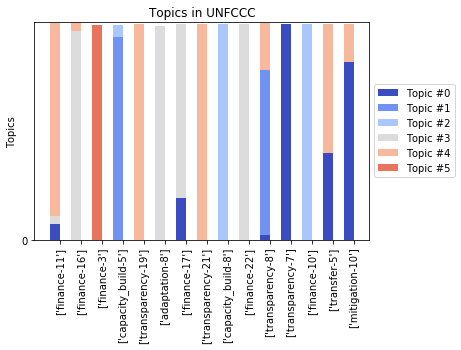

In [202]:
N = 15
ind = np.arange(N)
K = lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in UNFCCC')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

### Note:
Here we see some interesting composition of 'ingredients' (topics). With transparency, having high percentage of topic 5, similar to finance. Mitigation and transparency shares topic 4 overlapping. Although we don't know exactly what topics they are, we can see close relationship between different concepts.
    
    

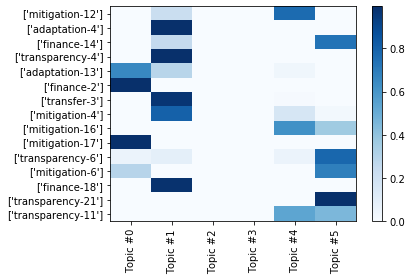

In [134]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [136]:
#Show the top 10 words in each topic
topicsDict = {}
for topicNum in range(lda.num_topics):
    topicWords = [w for w, p in lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,party,decision,party,gef,party,party
1,climate,party,gef,party,sbsta,gef
2,article,gef,decision,provide,emission,cop
3,cost,cop,country,climate,include,decision
4,emission,annex,capacity,fund,annex,change
5,report,fund,climate,adaptation,activity,climate
6,change,country,annex,national,country,national
7,include,adaptation,fund,change,cop,country
8,activity,capacity,activity,annex,technology,include
9,annex,build,technology,report,review,report


<Figure size 432x288 with 0 Axes>

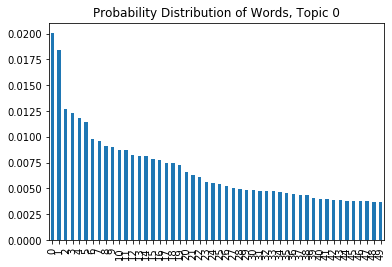

In [142]:
topic2_df = pandas.DataFrame(lda.show_topic(0, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 0')
plt.show()

<Figure size 432x288 with 0 Axes>

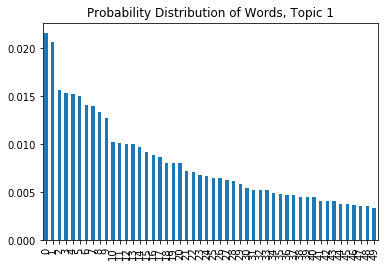

In [139]:
topic1_df = pandas.DataFrame(lda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

<Figure size 432x288 with 0 Axes>

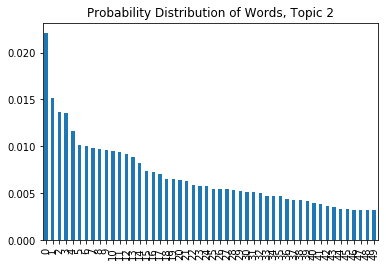

In [140]:
topic2_df = pandas.DataFrame(lda.show_topic(2, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 2')
plt.show()

<Figure size 432x288 with 0 Axes>

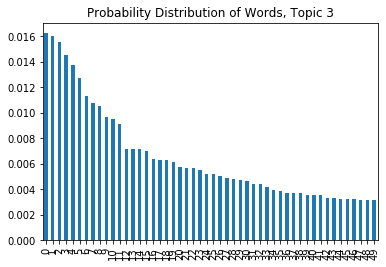

In [143]:
topic2_df = pandas.DataFrame(lda.show_topic(3, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 3')
plt.show()

<Figure size 432x288 with 0 Axes>

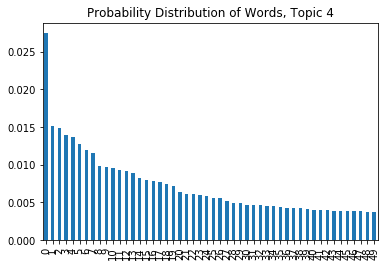

In [144]:
topic2_df = pandas.DataFrame(lda.show_topic(4, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 4')
plt.show()

<Figure size 432x288 with 0 Axes>

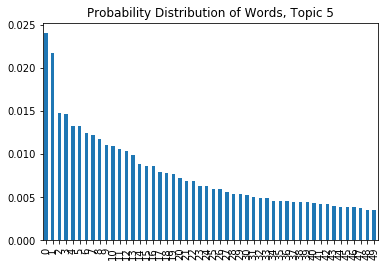

In [145]:
topic2_df = pandas.DataFrame(lda.show_topic(5, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 5')
plt.show()

# Exercise 4

I am using soap opera corpus and codes from last week for this section.

In [150]:
#Load soap opera texts
corpora_address = "../week-5/SOAP"
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [155]:
import zipfile
import pandas as pd

zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

soap_dict = {}
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [156]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
for soap in soap_dict:
    # since there were multiple lists
    #print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1
    



In [157]:
soap_df

,Soap Name,Tokenized Texts
62,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
63,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
64,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
65,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
66,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
67,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
68,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
69,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
70,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
71,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


In [158]:
#getting All my children 
amc = soap_df['Tokenized Texts'][62]

In [160]:
#Build character network in this opera
characters = {}
for token in amc:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [161]:
import networkx as nx

actor_network = nx.Graph()
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
        
i = 0
all_texts = []

for token in amc:
    i += 1
    if i > len(amc):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in amc[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(amc[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(amc[i:j]))

In [168]:
print(nx.info(actor_network))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 78
Average degree:  12.0000


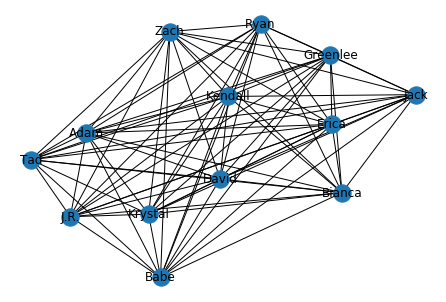

In [162]:
nx.draw(actor_network, with_labels=True)

In [170]:
dictionary = gensim.corpora.Dictionary(all_texts)

corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('amc.mm', corpus)
corpus_ = gensim.corpora.MmCorpus('amc.mm')
lda = gensim.models.ldamodel.LdaModel(corpus=corpus_, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')


In [169]:
topicsDict = {}
for topicNum in range(lda.num_topics):
    topicWords = [w for w, p in lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,ryan,want,oh,yes,come,go,okay,be,hey,good
1,tell,right,zach,love,need,man,get,know,david,kendall
2,say,thank,greenlee,oh,na,great,look,go,stay,like
3,think,stop,let,god,gon,son,right,talk,idea,time
4,jack,know,huh,wrong,find,hmm,wait,maybe,tad,long
5,hell,believe,ask,know,home,life,have,sorry,think,help
6,father,love,babe,right,know,sure,happen,want,meet,uh
7,keep,erica,question,think,hello,lose,j.r,think,lie,try
8,know,work,big,care,annie,be,know,well,run,know
9,away,life,have,leave,ha,mind,kill,fine,call,way


In [164]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = lda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

In [165]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(4, 0.22072995), (5, 0.60678464), (6, 0.16919787)]
[(4, 0.22387697), (5, 0.5952557), (6, 0.17756446)]
[(4, 0.21553124), (5, 0.6028085), (6, 0.17431648)]
[(4, 0.22011279), (5, 0.6076899), (6, 0.17063561)]
[(4, 0.21964014), (5, 0.6086296), (6, 0.16349636)]
[(4, 0.21288061), (5, 0.61192065), (6, 0.16713977)]
[(4, 0.21880683), (5, 0.5948199), (6, 0.17112584), (7, 0.015230281)]
[(4, 0.21432345), (5, 0.60707647), (6, 0.17579821)]
[(4, 0.22212155), (5, 0.6045435), (6, 0.17224751)]
[(4, 0.22035015), (5, 0.60082966), (6, 0.17080323)]
[(4, 0.21752052), (5, 0.5913936), (6, 0.17418444), (7, 0.016887577)]
[(4, 0.22543499), (5, 0.59733546), (6, 0.17446382)]
[(4, 0.22274712), (5, 0.6056808), (6, 0.16491698)]


### Note:
Here we see that all the main characters have high overlapping in topic 4, 5, 6 and 7, where the prominent words are need, home, life, sorry. These words arguably reflect the main characters' relation, which is being in the same family or closely related.
Other topics does not appear for the main characters. Those could be topics contributed by peripheral roles.